In the first 2 learning units, we saw the so-called **Bag of Words** vectorization of text. Text is transformed in vectors, constituted by counts or frequencies of words. This representation has the advantage of being simple and lasted for a very long time.

A possible improvement to this idea is, instead of considering single words, to consider sequences of them. So, you can create features for 2 consecutives words, or even 3. You can even consider sequences of letters, or phonems. This approach is called **n-grams** reprensentation, and it could be very effective as well. Since we are not going to cover it in this material, you can find very interesting explanation [here MISSING LINK]().

An important breakthrough in text representation has been made during recent past by using deep learning. The family of algorithms called **word2vec** is based on training neural network to automatically learn the more informative representation for text data. The networks are trained to produce vectors that embed semantic information extracted from text. For example,  words with similar meaning produces vectors that are close to one another in the vector space.

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# GenSim
import gensim

ModuleNotFoundError: No module named 'gensim'

Train those kind of models is **very** computationally expensive. The good news is that, once trained by those guys with the big computers, we can happily uses the trained models to project text to the feature space. 

The models had to be trained on text of the same language. So, nne of the few problems with such approach is that most of tools are only available for English language.

In [2]:
# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format('./lexvec.enwiki+newscrawl.300d.W.pos.vectors')

NameError: name 'gensim' is not defined

As we said earlier, we have some cool properties in this vector space. We can treat words as numbers. What do you expect from `woman + king - man`?

In [4]:
model.wv.most_similar(positive=['woman', 'king'], negative=['man'])

NameError: name 'model' is not defined

Ok, we're done playing around. Let's see how this thing works with real data.

In [ ]:
df = pd.read_csv('../data/uci-news-aggregator.csv')
df.dtypes

In [7]:
df = df[['TITLE', 'CATEGORY']]
df.columns = ['title', 'category']
df.head()

,title,category
0,"Fed official says weak data caused by weather,...",b
1,Fed's Charles Plosser sees high bar for change...,b
2,US open: Stocks fall after Fed official hints ...,b
3,"Fed risks falling 'behind the curve', Charles ...",b
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,b


In [8]:
sample_idxs = random.sample(range(1, 400000), 2500)

In [9]:
# Extract document tokens
documents = df['title'].values[sample_idxs]
tokens = [[word for word in document.split()] for document in documents]

In [10]:
# Convert tokens into vector representation
vectors = [np.array([model.wv[token] if token in model.wv else model.wv['the'] for token in sentence]) for sentence in tokens]

In [11]:
# Average word vectors to get document representation
means = [document.mean(axis=0) for document in vectors]

In [12]:
# Convert list of document representations into matrix
array = np.array(means)
array.shape

(2500, 300)

In [13]:
labels = df['category'].values[sample_idxs]

color_map = {'b':'r', 't':'g', 'e':'b', 'm':'c'}
colors = [color_map[label] for label in labels]
size = [10 for i in range(len(labels))]

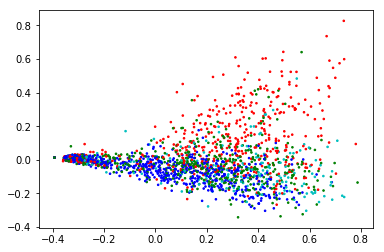

In [19]:
reduced_data = PCA(n_components=2).fit_transform(array)

plt.scatter(reduced_data[:,0], reduced_data[:,1], marker='.', c=colors, s=size)

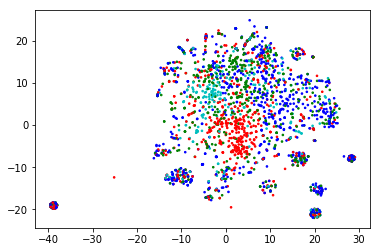

In [16]:
reduced_data = TSNE(n_components=2).fit_transform(array)

plt.scatter(reduced_data[:,0], reduced_data[:,1], marker='.', c=colors, s=size)

In [50]:
df['category'].unique()

array(['b', 't', 'e', 'm'], dtype=object)